In [1]:
import sys
import pickle

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

module_path = '/home/kinfi4/python/Propaganda-Analyzer/src/ETL'
if module_path not in sys.path:
    sys.path.append(module_path)

from services.domain.text_preprocessor import TextPreprocessor
from config.config import MAX_POST_LEN_IN_WORDS

In [2]:
NUMBER_OF_WORDS_TO_TOKENIZE = 20_000

In [3]:
def plot_hisory(history_dict: dict):
    plt.plot(history_dict['accuracy'])
    plt.plot(history_dict['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
def get_model_checkpoint_callback(filepath):
    return ModelCheckpoint(
        filepath,
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )

In [5]:
preprocessor = TextPreprocessor()

df = pd.read_csv(
    '../data/training-data/news-for-training.csv',
    names=['channel', 'text', 'date', 'type', 'sent']
)

df['text'] = df['text'].apply(preprocessor.preprocess_and_lemmatize)

In [6]:
df.head()

,channel,text,date,type,sent
0,раньше всех. ну почти.,президент эстония алар карис признать удаться ...,2022-05-17 18:20:01,economic,-1.0
1,раньше всех. ну почти.,россиянин февраль стать тратить раз новость ин...,2022-05-17 18:11:38,political,-1.0
2,раньше всех. ну почти.,суд приговорить эксполковник захарченко совоку...,2022-05-17 17:53:12,shelling,-1.0
3,раньше всех. ну почти.,евросоюз допустить украина закончиться оружие ...,2022-05-17 17:44:46,political,-1.0
4,раньше всех. ну почти.,сша активно привлекать участие боевой действие...,2022-05-17 17:43:05,political,-1.0


In [7]:
df['type'].value_counts()

political       579
shelling        376
economic        298
humanitarian    271
Name: type, dtype: int64

In [8]:
tokenizer = Tokenizer(num_words=NUMBER_OF_WORDS_TO_TOKENIZE)
tokenizer.fit_on_texts(df['text'])

preprocessor = TextPreprocessor(keras_tokenizer=tokenizer)

In [9]:
pickle.dump(tokenizer, open('./trained-models/keras-tokenizer.pk', 'wb'))

In [10]:
text_sequences = preprocessor.keras_tokenize_and_pad_text(
    df['text'],
    make_preprocessing=True,
    max_words_number=MAX_POST_LEN_IN_WORDS,
    padding='pre',
    truncating='post',
)

In [11]:
df['type'] = pd.factorize(df['type'])[0]

In [12]:
categorical_types = to_categorical(df['type'])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    text_sequences,
    categorical_types,
    test_size=0.2
)

# Building a LSTM model

In [14]:
lstm_model = Sequential([
    layers.Embedding(NUMBER_OF_WORDS_TO_TOKENIZE, 16, input_length=MAX_POST_LEN_IN_WORDS),
    layers.LSTM(32, recurrent_dropout=0.2),
    layers.Dense(4, activation='softmax')
])

In [15]:
lstm_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
save_callback = get_model_checkpoint_callback('./trained-models/lstm-news-type-prediction.h5')
history = lstm_model.fit(
    x=x_train,
    y=y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[save_callback]
)

Epoch 1/15
35/35 [==============================] - 9s 141ms/step - loss: 1.3720 - accuracy: 0.3651 - val_loss: 1.3561 - val_accuracy: 0.3279

Epoch 00001: val_accuracy improved from -inf to 0.32787, saving model to ./trained-models/lstm-news-type-prediction.h5
Epoch 2/15
35/35 [==============================] - 3s 94ms/step - loss: 1.3064 - accuracy: 0.3711 - val_loss: 1.2575 - val_accuracy: 0.4180

Epoch 00002: val_accuracy improved from 0.32787 to 0.41803, saving model to ./trained-models/lstm-news-type-prediction.h5
Epoch 3/15
35/35 [==============================] - 5s 138ms/step - loss: 1.0567 - accuracy: 0.5965 - val_loss: 1.0748 - val_accuracy: 0.6148

Epoch 00003: val_accuracy improved from 0.41803 to 0.61475, saving model to ./trained-models/lstm-news-type-prediction.h5
Epoch 4/15
35/35 [==============================] - 7s 197ms/step - loss: 0.7569 - accuracy: 0.7418 - val_loss: 0.9132 - val_accuracy: 0.6803

Epoch 00004: val_accuracy improved from 0.61475 to 0.68033, saving

In [17]:
score = lstm_model.evaluate(x_test, y_test, verbose=0)

print(f'The accuracy of the model = {round(score[1], 3)}')

The accuracy of the model = 0.748


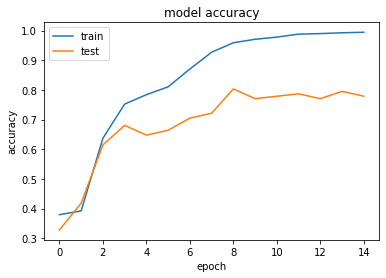

In [18]:
plot_hisory(history.history)

# Building CNN model

In [24]:
cnn_model = Sequential([
    layers.Embedding(NUMBER_OF_WORDS_TO_TOKENIZE, 8, input_length=MAX_POST_LEN_IN_WORDS),
    layers.Conv1D(250, 4, activation='relu', padding='same'),
    layers.GlobalMaxPool1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [25]:
cnn_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
save_callback = get_model_checkpoint_callback('./trained-models/cnn-news-type-prediction.h5')
history = cnn_model.fit(
    x=x_train,
    y=y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[save_callback]
)

Epoch 1/15
35/35 [==============================] - 3s 62ms/step - loss: 1.3609 - accuracy: 0.3441 - val_loss: 1.3681 - val_accuracy: 0.3279

Epoch 00001: val_accuracy improved from -inf to 0.32787, saving model to ./trained-models/cnn-news-type-prediction.h5
Epoch 2/15
35/35 [==============================] - 1s 39ms/step - loss: 1.2926 - accuracy: 0.3839 - val_loss: 1.2766 - val_accuracy: 0.3279

Epoch 00002: val_accuracy did not improve from 0.32787
Epoch 3/15
35/35 [==============================] - 1s 39ms/step - loss: 1.1294 - accuracy: 0.4434 - val_loss: 1.2002 - val_accuracy: 0.4754

Epoch 00003: val_accuracy improved from 0.32787 to 0.47541, saving model to ./trained-models/cnn-news-type-prediction.h5
Epoch 4/15
35/35 [==============================] - 2s 42ms/step - loss: 0.9281 - accuracy: 0.5941 - val_loss: 1.1483 - val_accuracy: 0.4918

Epoch 00004: val_accuracy improved from 0.47541 to 0.49180, saving model to ./trained-models/cnn-news-type-prediction.h5
Epoch 5/15
35/35 

In [27]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)

print(f'The accuracy of the model = {round(score[1], 3)}')

The accuracy of the model = 0.715


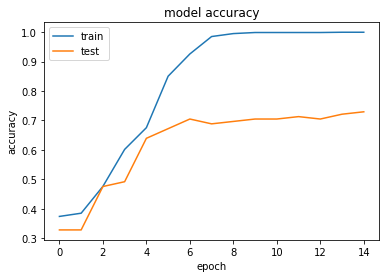

In [28]:
plot_hisory(history.history)